In [7]:
import os
import re
from pathlib import Path

import anndata
import pandas as pd
import scanpy as sc
import sklearn
import scipy
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

In [8]:
from wombat.utils import listfiles

In [9]:
# run_name = 'mCRC/combined_run_1'
# run_name = 'brca/oct_only_50_meta'
# run_name = 'pkd/K2100253'
# run_name = 'brca/alla_tumor_only'
# run_name = 'brca/alla_tumor_only_09202022'
# run_name = 'brca/alla_oct_only'
run_name = 'brca/alla_oct_only_10_meta'

In [10]:
output_dir = f'/storage1/fs1/dinglab/Active/Projects/estorrs/SpiceMix/analysis/{run_name}/inputs/files'
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [11]:
m = {}

In [12]:
fps = sorted(listfiles('/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/brca/',
                       regex=r'outs/filtered_feature_bc_matrix.h5$'))
len(fps), fps

(27,
 ['/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/brca/ffpe/HT397B1/H2/HT397B1-S1H2Fs4U1Bp1/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/brca/ffpe/HT397B1/H3/HT397B1-S1H3Fs1U1Bp1/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/brca/ffpe/HT425B1/H2/HT425B1-S1H2Fs1U1Bp1/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/brca/ffpe/HT480B1/H1/HT480B1-S1H1Fs1U1Bp1/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/brca/ffpe/HT480B1/H3/HT480B1-S1H3Fs1U1Bp1/outs/filtered_feature_bc_matrix.h5',
  '/storage1/fs1/dinglab/Active/Projects/Datasets/spatial_transcriptomics/cellranger_outs/brca/ffpe/HT486B1/H1/HT486B1-S1H1Fs1U1Bp1/outs/filtered_feat

In [13]:
sorted(set([fp.split('/')[-3] for fp in fps]))

['BR_206B1_U1',
 'BR_206B1_U2',
 'BR_206B1_U3',
 'BR_206B1_U4',
 'BR_206B1_U5',
 'HT297B1H1U1',
 'HT308B1-S1H1',
 'HT308B1-S1H4',
 'HT308B1-S1H5',
 'HT308B1-S2H5',
 'HT323B1-S1H1',
 'HT323B1-S1H3',
 'HT339B1-S1H3_U1',
 'HT339B1-S1H3_U2',
 'HT397B1-S1H2Fs4U1Bp1',
 'HT397B1-S1H3Fs1U1Bp1',
 'HT425B1-S1H2Fs1U1Bp1',
 'HT480B1-S1H1Fs1U1Bp1',
 'HT480B1-S1H3Fs1U1Bp1',
 'HT486B1-S1H1Fs1U1Bp1',
 'S17-41599-Fs1U1Bp1',
 'S18-25657-Fs1U1Bp1']

In [14]:
df = pd.read_csv('/storage1/fs1/dinglab/Active/Projects/estorrs/SpiceMix/analysis/brca/alla_tumor_only_09202022/All_ST_annotation_09202022.txt',
                sep='\t')
df = df[~pd.isnull(df['celltypespecific'])]
df = df[df['Preservation']=='OCT']
df

,Barcode,celltypespecific,Sample_ID,Preservation
14,AAACCTAAGCAGCCGG-1,IDC 4,HT308B1-S1H4,OCT
16,AAACGAAGAACATACC-1,DCIS 15,HT308B1-S1H4,OCT
63,AAATGCTCGTTACGTT-1,IDC 7,HT308B1-S1H4,OCT
69,AAATTAACGGGTAGCT-1,IDC 8,HT308B1-S1H4,OCT
75,AAATTGCGGCGGTTCT-1,IDC 7,HT308B1-S1H4,OCT
...,...,...,...,...
60257,TTCGGGCGCTAGTCTT-1,DCIS 8,HT297B1H1U1,OCT
60259,TTCGTTCAACGAAGTT-1,IDC 5,HT297B1H1U1,OCT
60269,TTCTGTTTCCTGTCGC-1,IDC 1,HT297B1H1U1,OCT
60273,TTCTTCCCTTTGATAT-1,DCIS 7,HT297B1H1U1,OCT


In [15]:
sorted(set(df['Sample_ID']))

['BRCA_206B1',
 'BR_206B1_U2',
 'BR_206B1_U3',
 'BR_206B1_U4',
 'BR_206B1_U5',
 'HT297B1H1U1',
 'HT308B1-S1H1',
 'HT308B1-S1H4',
 'HT308B1-S1H5',
 'HT323B1-S1H1',
 'HT339B1-S1H3-U1',
 'HT339B1-S1H3-U2']

In [16]:
m = {
    'BRCA_206B1': 'BR_206B1_U1',
}
df['sample_id'] = [m.get(x, x) for x in df['Sample_ID']]
df.index = [f'{s}_{b}' for b, s in zip(df['Barcode'], df['sample_id'])]
df

,Barcode,celltypespecific,Sample_ID,Preservation,sample_id
HT308B1-S1H4_AAACCTAAGCAGCCGG-1,AAACCTAAGCAGCCGG-1,IDC 4,HT308B1-S1H4,OCT,HT308B1-S1H4
HT308B1-S1H4_AAACGAAGAACATACC-1,AAACGAAGAACATACC-1,DCIS 15,HT308B1-S1H4,OCT,HT308B1-S1H4
HT308B1-S1H4_AAATGCTCGTTACGTT-1,AAATGCTCGTTACGTT-1,IDC 7,HT308B1-S1H4,OCT,HT308B1-S1H4
HT308B1-S1H4_AAATTAACGGGTAGCT-1,AAATTAACGGGTAGCT-1,IDC 8,HT308B1-S1H4,OCT,HT308B1-S1H4
HT308B1-S1H4_AAATTGCGGCGGTTCT-1,AAATTGCGGCGGTTCT-1,IDC 7,HT308B1-S1H4,OCT,HT308B1-S1H4
...,...,...,...,...,...
HT297B1H1U1_TTCGGGCGCTAGTCTT-1,TTCGGGCGCTAGTCTT-1,DCIS 8,HT297B1H1U1,OCT,HT297B1H1U1
HT297B1H1U1_TTCGTTCAACGAAGTT-1,TTCGTTCAACGAAGTT-1,IDC 5,HT297B1H1U1,OCT,HT297B1H1U1
HT297B1H1U1_TTCTGTTTCCTGTCGC-1,TTCTGTTTCCTGTCGC-1,IDC 1,HT297B1H1U1,OCT,HT297B1H1U1
HT297B1H1U1_TTCTTCCCTTTGATAT-1,TTCTTCCCTTTGATAT-1,DCIS 7,HT297B1H1U1,OCT,HT297B1H1U1


In [17]:
# # only running for certain samples
# keep = [
#     '206',
#     '308',
#     '323',
#     '339'
# ]
# fps = [fp for fp in fps if any([True if x in fp else False for x in keep])]
# fps

HT397B1-S1H2Fs4U1Bp1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `dist

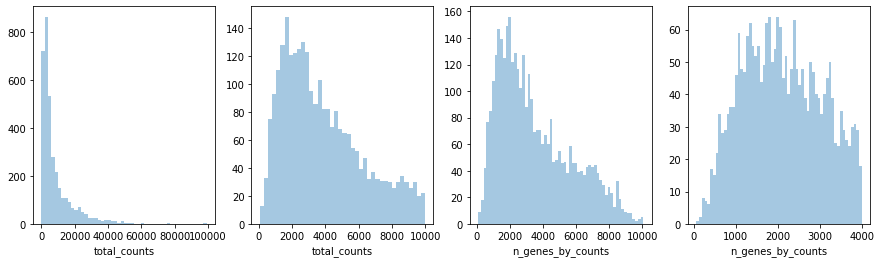

HT397B1-S1H3Fs1U1Bp1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


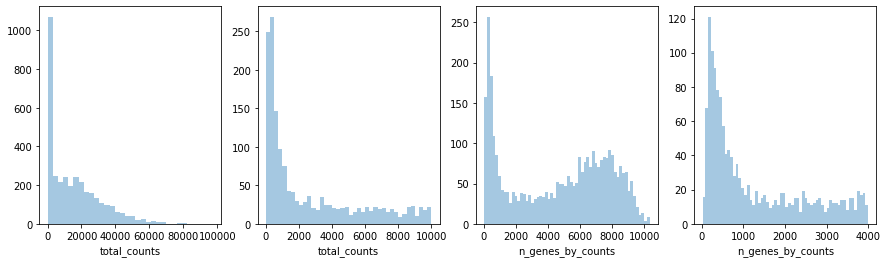

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


HT425B1-S1H2Fs1U1Bp1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


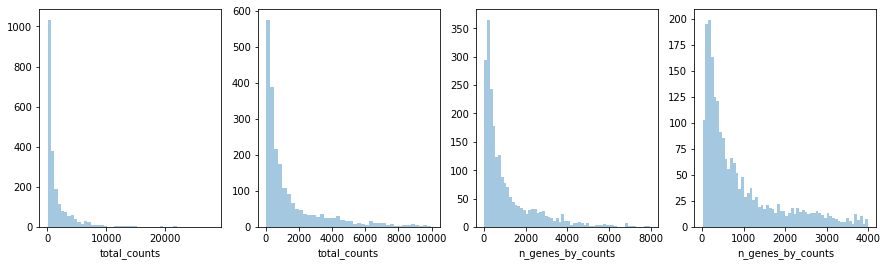

HT480B1-S1H1Fs1U1Bp1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


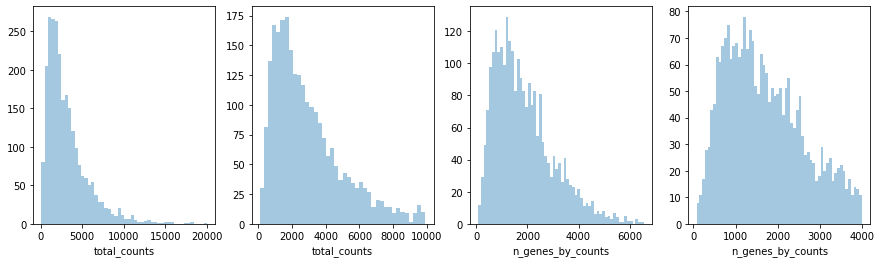

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


HT480B1-S1H3Fs1U1Bp1


/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


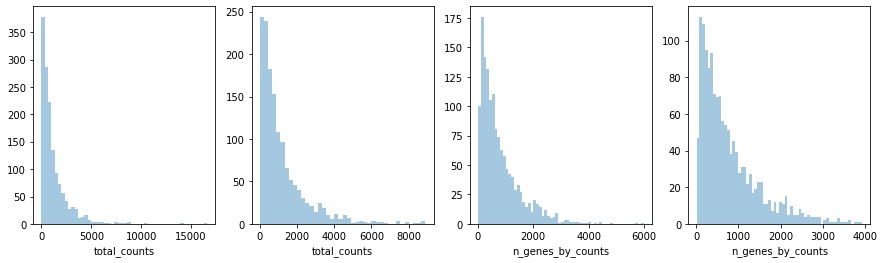

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


HT486B1-S1H1Fs1U1Bp1


/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


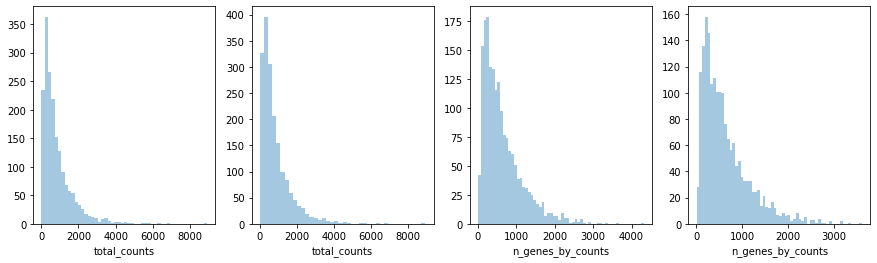

S17-41599-Fs1U1Bp1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


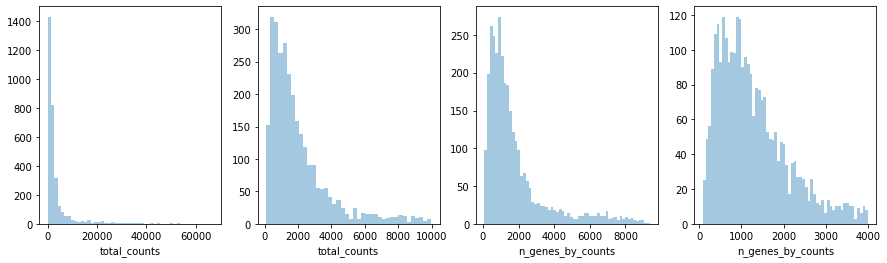

S18-25657-Fs1U1Bp1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


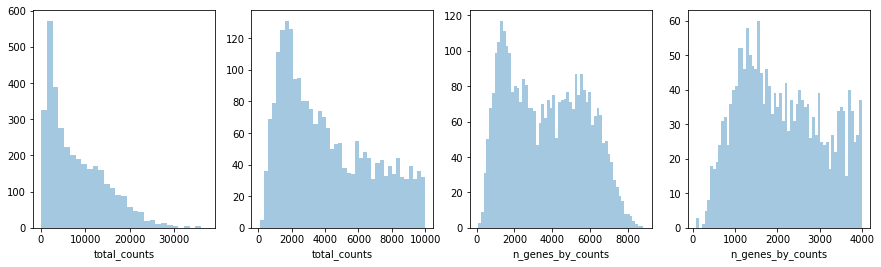

BR_206B1_U1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


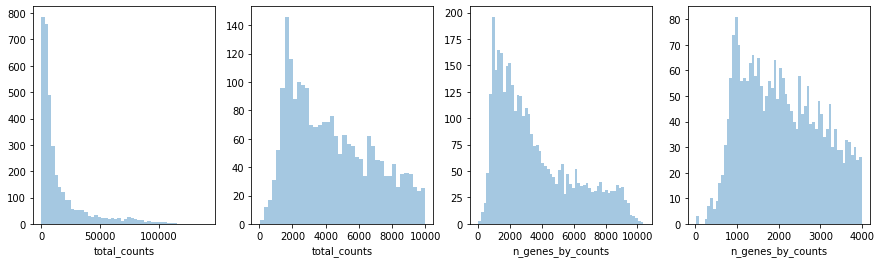

BR_206B1_U2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


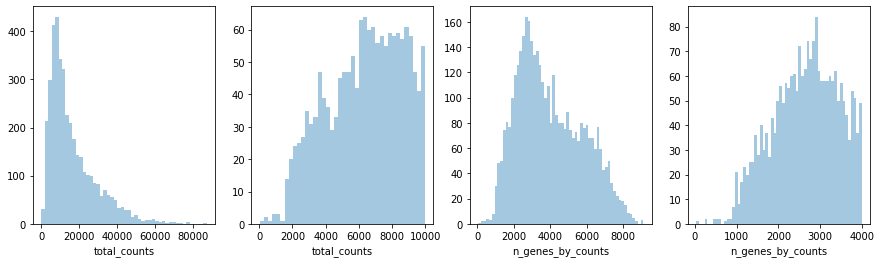

BR_206B1_U3


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


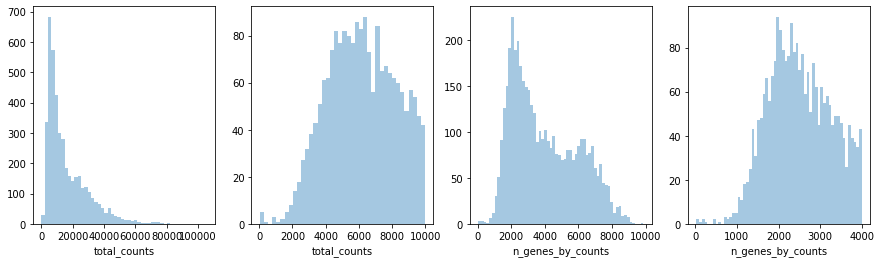

BR_206B1_U4


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


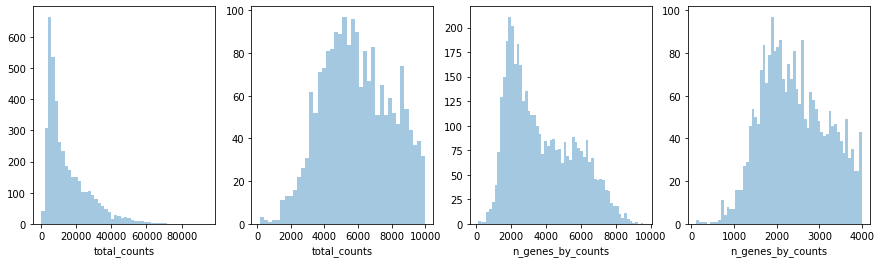

BR_206B1_U5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


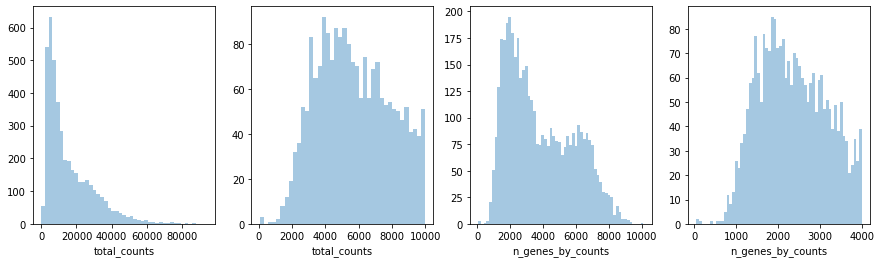

HT297B1H1U1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


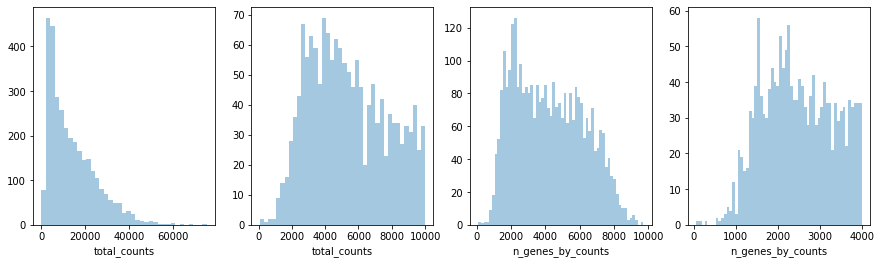

HT308B1-S1H1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


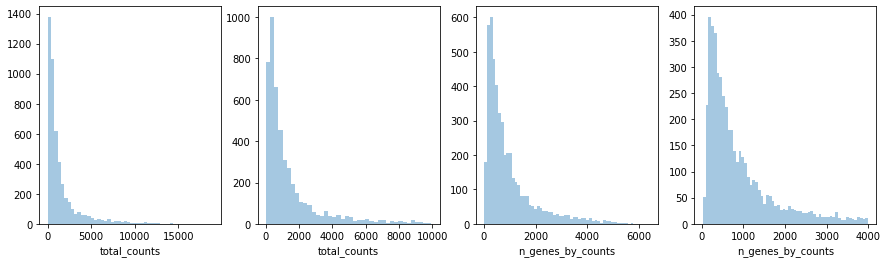

HT308B1-S1H4


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


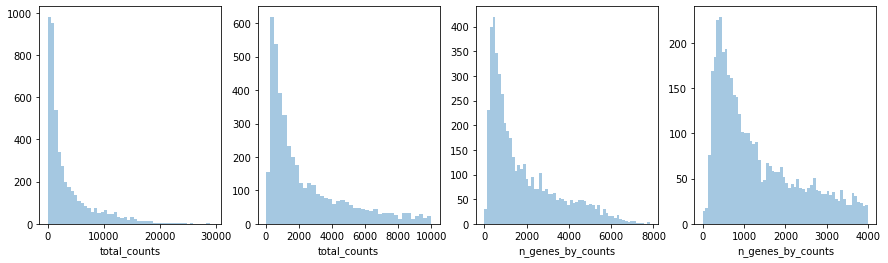

HT308B1-S1H5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


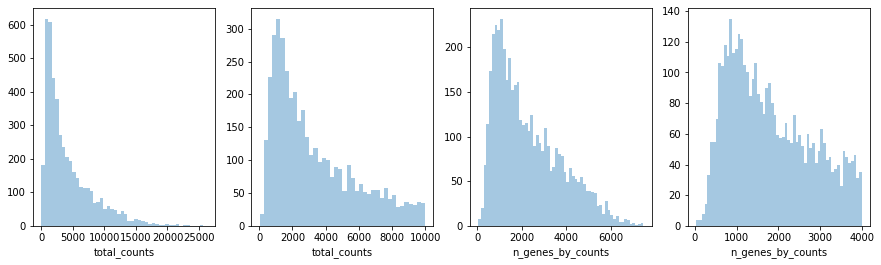

HT308B1-S2H5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


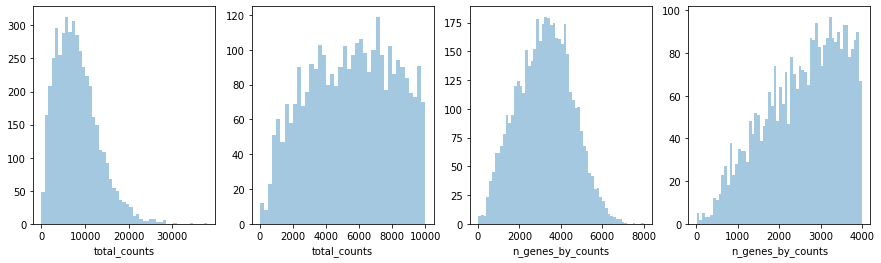

HT323B1-S1H1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


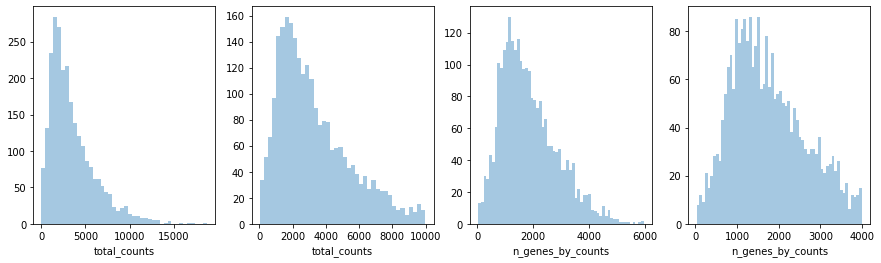

HT323B1-S1H3


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


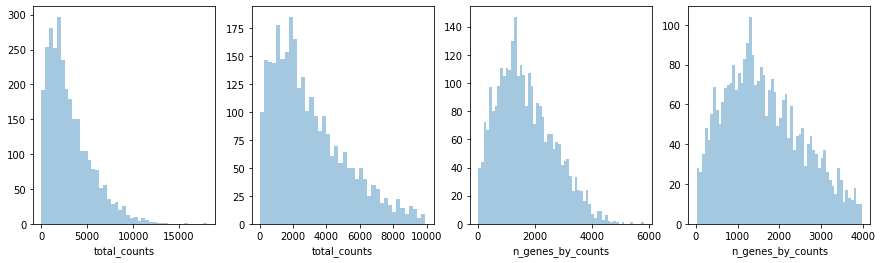

HT339B1-S1H3_U1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/envs/SpiceMix/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


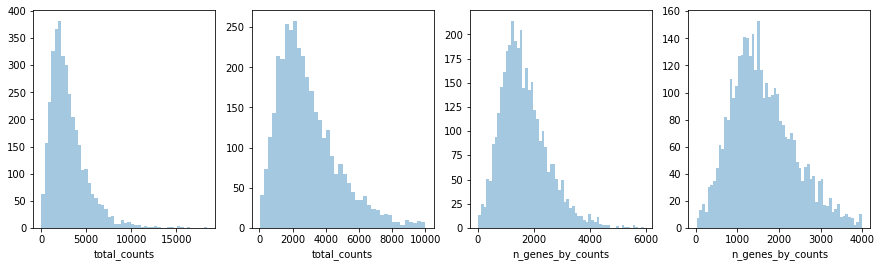

In [ ]:
sample_to_adata = {}
for i, fp in enumerate(fps):
    s = fp.split('/')[-3]
    print(s)
    a = sc.read_visium(fp.replace('/filtered_feature_bc_matrix.h5', ''))
    a.var_names_make_unique()
    a.var["mt"] = a.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(a, qc_vars=["mt"], inplace=True)
    a.obs.index = [f'{s}_{x}' for x in a.obs.index]
    a.obs['sample_id'] = s
    a.obs['fov'] = str(i)
    sample_to_adata[s] = a

    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    sns.distplot(a.obs["total_counts"], kde=False, ax=axs[0])
    sns.distplot(a.obs["total_counts"][a.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
    sns.distplot(a.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sns.distplot(a.obs["n_genes_by_counts"][a.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
    plt.show()

sample_to_adata.keys()

In [ ]:
for s, a in sample_to_adata.items():
    print(a.shape)
#     sc.pp.filter_cells(a, min_counts=1000)
#     a = a[a.obs["pct_counts_mt"] < 20]
    
    sc.pp.normalize_total(a, target_sum=10e4)
    sc.pp.log1p(a)
    
    a.raw = a
    
    sample_to_adata[s] = a
    
    print(a.shape)

In [ ]:

keep = []
for s, a in sample_to_adata.items():
    f = df[df['sample_id']==s]
    
    if f.shape[0]:
        keep.append(s)
        print(a[f.index.to_list()].shape)
        a = a[f.index.to_list()]
        sample_to_adata[s] = a
        

In [ ]:
keep

In [ ]:
sample_to_adata = {s:a for s, a in sample_to_adata.items() if s in keep}

In [ ]:
def spot_to_neighbors(adata, n_neighbors=7, radius=400.):
    X = adata.obsm['spatial']
    nbrs = NearestNeighbors(algorithm='ball_tree').fit(X)
    
    g = nbrs.kneighbors_graph(X, n_neighbors=n_neighbors, )
#     g = nbrs.radius_neighbors_graph(X, radius=radius, )
    rows, cols, _ = scipy.sparse.find(g)
    
    spot_to_neighbhors = {x:[] for x in adata.obs.index.to_list()}
    for r, c in zip(rows, cols):
        cid = adata.obs.index[r]
        spot_to_neighbhors[cid].append(adata.obs.index[c])
    spot_to_neighbhors = {spot:[nbhr for nbhr in nbhrs if nbhr != spot]
                          for spot, nbhrs in spot_to_neighbhors.items()}
    return spot_to_neighbhors

In [ ]:
for s, a in sample_to_adata.items():
    a.uns['spot_to_neighbors'] = spot_to_neighbors(a)

In [ ]:
test = next(iter(sample_to_adata.values()))
test.obs['highlight'] = ['yes' if x in test.uns['spot_to_neighbors'][test.obs.index[100]] else 'no'
                      for x in test.obs.index]
sc.pl.spatial(test, color='highlight')

In [ ]:
combined = anndata.concat(sample_to_adata.values())
combined.uns['spot_to_neighbors'] = {}
for s, a in sample_to_adata.items():
    combined.uns['spot_to_neighbors'].update(a.uns['spot_to_neighbors'])

combined

In [ ]:
# limit to genes with > 1% expression accross samples
combined.raw = combined
sc.pp.filter_genes(combined, min_counts=int(.01 * combined.shape[0]))
combined

In [ ]:
genes = combined.var.index.to_list()

In [22]:
for s, a in sample_to_adata.items():
    print(s)
    fov = a.obs['fov'][0]
    gene_table = a[:, genes].var[[]]
    gene_table.index.name = 'Gene'

    meta = a.obs[['array_row', 'array_col']]
    meta.columns = ['coor Y', 'coor X']

    exp = pd.DataFrame(data=a[:, genes].X.toarray(), columns=genes, index=a.obs.index)

    spot_to_index = {spot:i for i, spot in enumerate(a.obs.index)}
    edges = [[spot_to_index[spot1], spot_to_index[spot2]]
             for spot1, nbhrs in a.uns['spot_to_neighbors'].items()
             for spot2 in nbhrs]
    edges = pd.DataFrame(data=edges, columns=['Spot', 'Neighbor'])

    gene_table.to_csv(os.path.join(output_dir, f'genes_{fov}.txt'), sep='\t', index=True, header=False)
    meta.to_csv(os.path.join(output_dir, f'meta_{fov}.txt'), sep='\t', index=False, header=True)
    exp.to_csv(os.path.join(output_dir, f'expression_{fov}.txt'), sep='\t', index=False, header=False)
    edges.to_csv(os.path.join(output_dir, f'neighborhood_{fov}.txt'), sep='\t', index=False, header=False)

BR_206B1_U1
BR_206B1_U2
BR_206B1_U3
BR_206B1_U4
BR_206B1_U5
HT297B1H1U1
HT308B1-S1H1
HT308B1-S1H4
HT308B1-S1H5
HT323B1-S1H1


In [23]:
directory = os.path.join(output_dir, '..', 'input_adatas')
Path(directory).mkdir(parents=True, exist_ok=True)
for s, a in sample_to_adata.items():
    a.write_h5ad(os.path.join(directory, f'{s}.h5ad'))

... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'sample_id' as categorical
... storing 'fov' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'sample_id' as categorical
... storing 'fov' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'sample_id' as categorical
... storing 'fov' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'sample_id' as categorical
... storing 'fov' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
.